In [26]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import GradientBoostingClassifier

from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt


import tensorflow as tf
import keras
from random import randint
from keras.utils import np_utils
from tensorflow.keras.applications import ResNet50

from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D


def convert_onehotencoder(input_column):
    unique_values = input_column.unique()
    dummy_df = pd.DataFrame(columns=unique_values)
    for values in unique_values:
        dummy_df[values] = np.where(input_column ==values,1,0)
    return dummy_df

def create_confusion_matrix(Y,predicted_Y):
    labels = np.unique(Y.to_numpy())
    #get the confusion matrix
    confusion_matrix = metrics.confusion_matrix(Y,predicted_Y)
    #turn this into a  dataframe
    matrix_df = pd.DataFrame(confusion_matrix)
    #plot the result
    ax = plt.axes()
    sns.set(font_scale=1.3)
    plt.figure(figsize=(10,7))
    sns.heatmap(matrix_df, annot=True, fmt="g", ax=ax, cmap="magma")
    #set axis titles
    ax.set_title('Confusion Matrix - Decision Tree')
    ax.set_xlabel("Predicted label", fontsize =15)
    #ax.set_xticklabels(['']+labels)
    ax.set_ylabel("True Label", fontsize=15)
    ax.set_yticklabels(list(labels), rotation = 0)
    plt.show()

In [12]:
df = pd.read_csv('../input/autism-screening-for-toddlers/Toddler Autism dataset July 2018.csv',na_values='?')
df.head()

,Case_No,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,Age_Mons,Qchat-10-Score,Sex,Ethnicity,Jaundice,Family_mem_with_ASD,Who completed the test,Class/ASD Traits
0,1,0,0,0,0,0,0,1,1,0,1,28,3,f,middle eastern,yes,no,family member,No
1,2,1,1,0,0,0,1,1,0,0,0,36,4,m,White European,yes,no,family member,Yes
2,3,1,0,0,0,0,0,1,1,0,1,36,4,m,middle eastern,yes,no,family member,Yes
3,4,1,1,1,1,1,1,1,1,1,1,24,10,m,Hispanic,no,no,family member,Yes
4,5,1,1,0,1,1,1,1,1,1,1,20,9,f,White European,no,yes,family member,Yes


In [31]:
X = df.iloc[:,1:18]
Y = df.iloc[:,18]

new_df = df[['Sex','Ethnicity','Jaundice','Family_mem_with_ASD', 'Who completed the test']]

X = X.drop('Sex', axis = 1)
X = X.drop('Ethnicity', axis = 1)
X = X.drop('Jaundice', axis = 1)
X = X.drop('Family_mem_with_ASD', axis = 1)
X = X.drop('Who completed the test', axis = 1)

In [32]:
for column in new_df:
    new_df[column]= new_df[column].map(lambda x: x.lower())
    new_df[column].replace('^\s+', '', regex=True, inplace=True) #front
    new_df[column].replace('\s+$', '', regex=True, inplace=True) #end

for column in new_df:
    print(column)
    dummy_df = convert_onehotencoder(new_df[column])
    X = pd.concat([X,dummy_df], axis=1)

Sex
Ethnicity
Jaundice
Family_mem_with_ASD
Who completed the test


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [34]:
Y = pd.DataFrame(Y)
Y = pd.get_dummies(Y,drop_first=True)

In [38]:
from sklearn.model_selection import train_test_split
trainX,testX,trainY,testY = train_test_split(X,Y,test_size=0.2,random_state=101)

### DecisionTreeClassifier

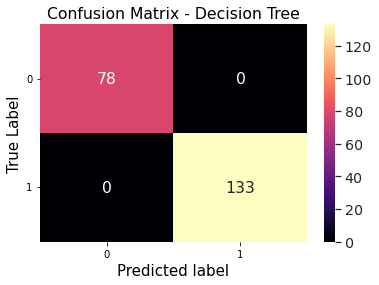

<Figure size 720x504 with 0 Axes>

Decision Tree Accuracy 1.0


In [39]:
model1 = DecisionTreeClassifier()
model1.fit(trainX,trainY)
create_confusion_matrix(testY, model1.predict(testX))
print("Decision Tree Accuracy",metrics.accuracy_score(testY, model1.predict(testX)))

### RandomForestClassifier

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


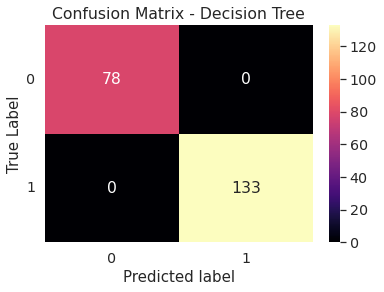

<Figure size 720x504 with 0 Axes>

Random Forest Accuracy 1.0


In [41]:
model2 = RandomForestClassifier(max_features=5, n_estimators=20)
model2.fit(trainX,trainY)
create_confusion_matrix(testY, model2.predict(testX))
print("Random Forest Accuracy",metrics.accuracy_score(testY, model2.predict(testX)))

In [42]:
# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-2, 1e-3, 1e-4, 1e-5],
                     'C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]},
                    {'kernel': ['sigmoid'], 'gamma': [1e-2, 1e-3, 1e-4, 1e-5],
                     'C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]},
                    {'kernel': ['linear'], 'C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]}
                   ]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(C=1), tuned_parameters, cv=5,
                       scoring='%s_macro' % score)
    clf.fit(trainX, trainY)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
   
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

# Tuning hyper-parameters for precision



/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted sa

Best parameters set found on development set:

{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}

Grid scores on development set:

0.353 (+/-0.002) for {'C': 0.001, 'gamma': 0.01, 'kernel': 'rbf'}
0.353 (+/-0.002) for {'C': 0.001, 'gamma': 0.001, 'kernel': 'rbf'}
0.353 (+/-0.002) for {'C': 0.001, 'gamma': 0.0001, 'kernel': 'rbf'}
0.353 (+/-0.002) for {'C': 0.001, 'gamma': 1e-05, 'kernel': 'rbf'}
0.971 (+/-0.032) for {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
0.353 (+/-0.002) for {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}
0.353 (+/-0.002) for {'C': 0.1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.353 (+/-0.002) for {'C': 0.1, 'gamma': 1e-05, 'kernel': 'rbf'}
0.971 (+/-0.032) for {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
0.353 (+/-0.002) for {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}
0.353 (+/-0.002) for {'C': 0.1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.353 (+/-0.002) for {'C': 0.1, 'gamma': 1e-05, 'kernel': 'rbf'}
1.000 (+/-0.000) for {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
0.998 (+/-0.008) for {'C':

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

Best parameters set found on development set:

{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}

Grid scores on development set:

0.500 (+/-0.000) for {'C': 0.001, 'gamma': 0.01, 'kernel': 'rbf'}
0.500 (+/-0.000) for {'C': 0.001, 'gamma': 0.001, 'kernel': 'rbf'}
0.500 (+/-0.000) for {'C': 0.001, 'gamma': 0.0001, 'kernel': 'rbf'}
0.500 (+/-0.000) for {'C': 0.001, 'gamma': 1e-05, 'kernel': 'rbf'}
0.941 (+/-0.069) for {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
0.500 (+/-0.000) for {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}
0.500 (+/-0.000) for {'C': 0.1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.500 (+/-0.000) for {'C': 0.1, 'gamma': 1e-05, 'kernel': 'rbf'}
0.941 (+/-0.069) for {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
0.500 (+/-0.000) for {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}
0.500 (+/-0.000) for {'C': 0.1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.500 (+/-0.000) for {'C': 0.1, 'gamma': 1e-05, 'kernel': 'rbf'}
1.000 (+/-0.000) for {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
0.999 (+/-0.003) for {'C':

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

In [43]:
best_kernel = clf.best_params_ ['kernel']

if best_kernel=='rbf' or best_kernel=='sigmoid':
    my_svm = SVC(C=clf.best_params_['C'], kernel=best_kernel, gamma=clf.best_params_['gamma'], probability=True)
else:
    my_svm = SVC(C=clf.best_params_['C'], kernel=best_kernel, probability=True)
my_svm.fit(trainX, trainY)

print("Support Vector Machine accuracy: ",metrics.accuracy_score(testY, my_svm.predict(testX)))

Support Vector Machine accuracy:  1.0


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [44]:
GDBclf = GradientBoostingClassifier(n_estimators = 40, learning_rate = 0.01, max_depth = 50, random_state = 0).fit(trainX, trainY)
GDBclf.score(testX, testY)

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1.0

In [45]:
def resnet3channelTo1channel(model):
        resnet_org_model = model
        resnet_org_model_config = resnet_org_model.get_config()  # this is a dictionary
   
        mymodel_config = resnet_org_model_config
   
        # Convert the first layers (i.e., input layer) tuple type to list type to enable it editable
        mymodel_config['layers'][0]['config']['batch_input_shape'] = list(mymodel_config['layers'][0]['config']['batch_input_shape'])
   
        # Now change the value of channel from 3 to 1
        mymodel_config['layers'][0]['config']['batch_input_shape'][-1] = 1
   
        # Now make the type from list to tuple
        mymodel_config['layers'][0]['config']['batch_input_shape'] = tuple(mymodel_config['layers'][0]['config']['batch_input_shape'])
   
        # Build the model
        mymodel = tf.keras.Model.from_config(mymodel_config)
   
        # Copy the names of layers in the pretrained model to a variable
        mymodel_updated_layers_names = [mymodel_config['layers'][x]['name'] for x in range(len(mymodel_config['layers']))]
   
        # Copy the name of the first convolution layer that has weights for the 3 channels
        first_conv_name = mymodel_updated_layers_names[2]

        #Now copy the weights from pretrained model to mymodel
        for layer in resnet_org_model.layers:
            if layer.name in mymodel_updated_layers_names:
                if layer.get_weights() != []:
                    target_layer = mymodel.get_layer(layer.name)
                   
                    if layer.name in first_conv_name:
                        #print(first_conv_name)
                        weights = layer.get_weights()[0]
                        biases = layer.get_weights()[1]
                        averageWeights = np.mean(weights, axis=-2).reshape(weights[:,:,-1:,:].shape)
                        weights_single_channel = averageWeights;
                        target_layer.set_weights([weights_single_channel, biases])
                        target_layer.trainable = False
                    else:
                        target_layer.set_weights(layer.get_weights())
                        target_layer.trainable = False
        return mymodel    
   
def build_resnet50_one_chanel_input(input_shape,n_classes):
     
      image_size = 28
      inputstemp = tf.keras.Input(input_shape)

      resnet50_org = ResNet50(include_top=False, weights = "imagenet", input_tensor = inputstemp)
      resnet50 = resnet3channelTo1channel(resnet50_org)
     
      inputs = tf.keras.Input(shape=(image_size, image_size,1))
      x = resnet50(inputs, training=False)
      x = tf.keras.layers.GlobalAveragePooling2D()(x)
      x = tf.keras.layers.Dropout(0.2)(x)
      outputs = tf.keras.layers.Dense((n_classes),activation="softmax")(x)

      model = tf.keras.Model(inputs, outputs, name ='Eating_post_classification_ResNet50')
      model.summary()
     
      return model
 
def dependent_variable_one_hot_encoding(y):
    # one-hot encoding using keras numpy-related utilities
    n_classes = np.array(np.shape(np.unique(y)))[0]
    print("Shape before one-hot encoding: ", y.shape)
    Y_encoded = np_utils.to_categorical(y, n_classes)
    print("Shape after one-hot encoding: ", Y_encoded.shape)
    return Y_encoded

In [46]:
n_classes = np.array(np.shape(np.unique(Y)))[0]
input_shape = (28, 28, 3)
clf_cnn = build_resnet50_one_chanel_input(input_shape, n_classes)

2023-01-02 05:41:36.023084: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


94781440/94765736 [==============================] - 1s 0us/step


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Model: "Eating_post_classification_ResNet50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
resnet50 (Functional)        (None, 1, 1, 2048)        23581440  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 23,585,538
Trainable params: 4,098
Non-trainable params: 23,581,440
_________________________________________________________________


In [51]:
encoder_dnn = Sequential()
encoder_dnn.add(Dense(100, input_shape=(trainX.shape[1],), activation='relu'))
encoder_dnn.add(Dense(200, activation='relu'))
#encoder_dnn.add(Dense(784, activation='softmax'))
encoder_dnn.add(Dense(784, activation='relu'))
encoder_dnn.add(tf.keras.layers.Reshape((28, 28,1)))
encoder_dnn.add(clf_cnn)
encoder_dnn.summary()

#merged = tf.keras.layers.Concatenate([encoder_dnn, clf_cnn])
#final_model = tf.keras.Model(inputs=encoder_dnn.input, outputs=clf_cnn.output)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 100)               3400      
_________________________________________________________________
dense_5 (Dense)              (None, 200)               20200     
_________________________________________________________________
dense_6 (Dense)              (None, 784)               157584    
_________________________________________________________________
reshape_1 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
Eating_post_classification_R (None, 2)                 23585538  
Total params: 23,766,722
Trainable params: 185,282
Non-trainable params: 23,581,440
_________________________________________________________________


In [63]:
Y = dependent_variable_one_hot_encoding(Y)

Shape before one-hot encoding:  (1054, 1)
Shape after one-hot encoding:  (1054, 2)


In [64]:
trainX,testX,trainY,testY = train_test_split(X,Y,test_size=0.2,random_state=101)

In [ ]:
#clf_compiled_dnn = tf.keras.Model(encoder_dnn,clf_cnn)
#clf_compiled_dnn =
encoder_dnn.compile(loss='CategoricalCrossentropy', metrics = ['accuracy'], optimizer='adam')

# Ytemp = dependent_variable_one_hot_encoding(Y)

# trainYtemp = Ytemp[1:844,:]
# testYtemp = Ytemp[844:-1,:]

encoder_dnn.fit(trainX.astype(float),trainY.astype(float), epochs = 50)

predOutput = encoder_dnn.predict(testX.astype(float))

encoder_dnn.evaluate(testX.astype(float), testX)
create_confusion_matrix(pd.DataFrame(trainY.argmax(axis=1)), pd.DataFrame(predOutput.argmax(axis=1)))

Epoch 1/50
27/27 [==============================] - 14s 287ms/step - loss: 0.0403 - accuracy: 0.9858
Epoch 2/50
27/27 [==============================] - 8s 281ms/step - loss: 0.0019 - accuracy: 1.0000
Epoch 3/50
27/27 [==============================] - 8s 284ms/step - loss: 2.4578e-04 - accuracy: 1.0000
Epoch 4/50
27/27 [==============================] - 9s 317ms/step - loss: 1.4983e-04 - accuracy: 1.0000
Epoch 5/50
27/27 [==============================] - 8s 279ms/step - loss: 3.9145e-05 - accuracy: 1.0000
Epoch 6/50
27/27 [==============================] - 8s 286ms/step - loss: 4.4966e-05 - accuracy: 1.0000
Epoch 7/50
27/27 [==============================] - 8s 288ms/step - loss: 2.1856e-05 - accuracy: 1.0000
Epoch 8/50
27/27 [==============================] - 8s 310ms/step - loss: 2.5552e-05 - accuracy: 1.0000
Epoch 9/50
27/27 [==============================] - 7s 270ms/step - loss: 3.6027e-05 - accuracy: 1.0000
Epoch 10/50
27/27 [==============================] - 7s 274ms/step - lo